In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Conv1D
import tensorflow as tf

In [2]:
df = pd.read_csv('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки/airline-passengers.csv')

In [3]:
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


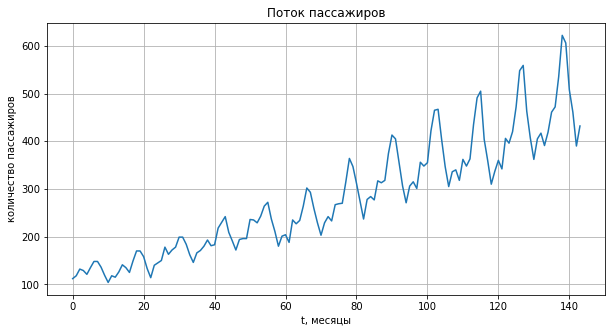

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(df['Passengers'])), df['Passengers'])
plt.grid('on')
plt.xlabel('t, месяцы')
plt.ylabel('количество пассажиров')
plt.title('Поток пассажиров')
plt.show()

Имеем нестационарный временной ряд, наблюдается восходящий тренд и сезонность.

[1.         0.94804734 0.87557484 0.80668116 0.75262542 0.71376997
 0.6817336  0.66290439 0.65561048 0.67094833 0.70271992 0.74324019
 0.76039504 0.71266087 0.64634228 0.58592342 0.53795519 0.49974753
 0.46873401 0.44987066 0.4416288  0.45722376 0.48248203 0.51712699
 0.53218983 0.49397569 0.43772134 0.3876029  0.34802503 0.31498388
 0.28849682 0.27080187 0.26429011 0.27679934 0.2985215  0.32558712
 0.3370236 ]


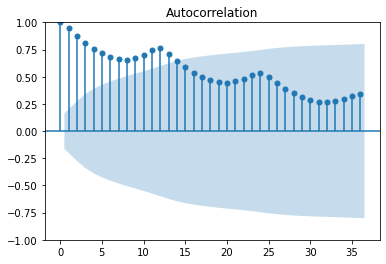

In [5]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

x = df['Passengers']

print(sm.tsa.acf(x, nlags = 36))

fig = tsaplots.plot_acf(x, lags = 36)
plt.show()

<font size = 3><div style="text-align: justify">**Вариант 1:**</div></font>

In [6]:
df = df['Passengers'].values.astype(float)
df

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1)) #feature_range=(-1, 1)
df_norm = scaler.fit_transform(df.reshape(-1, 1))
df_norm

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [8]:
#Делим выборку на обучение и тест
df_norm_train = int(len(df_norm) * 0.84)
df_norm_test = len(df_norm) - df_norm_train
train, test = df_norm[0:df_norm_train,:], df_norm[df_norm_train:len(df_norm),:]
print(len(train), len(test))

120 24


In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [12]:
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1, activation='linear'))

#model.add(LSTM(32, input_shape=(1, look_back), return_sequences=True))
#model.add(LSTM(32, return_sequences=True))
#model.add(Conv1D(64, 1, activation='linear'))
#model.add(Conv1D(64, 1, activation='linear'))
#model.add(Flatten())
#model.add(Dense(3, activation='linear'))
#model.add(Dense(1, activation='linear'))

#model.add(Conv1D(50, 1, input_shape = (1, look_back), activation="linear"))
#model.add(Flatten())
#model.add(Dense(10, activation="linear"))
#model.add(Dense(1, activation="linear"))

#model.add(LSTM(50, return_sequences = True, input_shape = (1, look_back)))
#model.add(Dropout(0.2))
#model.add(LSTM(50, return_sequences = True))
#model.add(Dropout(0.2))
##regressor.add(LSTM(units = 50,return_sequences = True)) # Activate it to see effect
##regressor.add(Dropout(0.2))
#model.add(LSTM(50))
#model.add(Dropout(0.2))
#model.add(Dense(1)) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [171]:
#lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

In [174]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)
#mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)

In [13]:
model.compile(loss='mse', optimizer='adam', metrics = ['mae'])

history = model.fit(X_train, Y_train, 
                    epochs = 200, 
                    batch_size = 1, 
                    verbose = 1,
                    #callbacks=[mc, lr_schedule, early_stopping],
                    validation_data = (X_test, Y_test))

Epoch 1/200
118/118 [==============================] - 4s 7ms/step - loss: 0.0762 - mae: 0.2107 - val_loss: 0.2735 - val_mae: 0.5042
Epoch 2/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0331 - mae: 0.1424 - val_loss: 0.1611 - val_mae: 0.3798
Epoch 3/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0225 - mae: 0.1220 - val_loss: 0.1071 - val_mae: 0.3039
Epoch 4/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0193 - mae: 0.1155 - val_loss: 0.0927 - val_mae: 0.2815
Epoch 5/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0163 - mae: 0.1055 - val_loss: 0.0707 - val_mae: 0.2424
Epoch 6/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0137 - mae: 0.0968 - val_loss: 0.0613 - val_mae: 0.2243
Epoch 7/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0114 - mae: 0.0875 - val_loss: 0.0471 - val_mae: 0.1925
Epoch 8/200
118/118 [==============================] - 0s 2ms/step - 

118/118 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0438 - val_loss: 0.0099 - val_mae: 0.0856
Epoch 63/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0431 - val_loss: 0.0107 - val_mae: 0.0892
Epoch 64/200
118/118 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0425 - val_loss: 0.0099 - val_mae: 0.0862
Epoch 65/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0429 - val_loss: 0.0110 - val_mae: 0.0905
Epoch 66/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0432 - val_loss: 0.0107 - val_mae: 0.0892
Epoch 67/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0433 - val_loss: 0.0097 - val_mae: 0.0841
Epoch 68/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0445 - val_loss: 0.0101 - val_mae: 0.0869
Epoch 69/200
118/118 [==============================] - 0s 2ms/step - loss:

118/118 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0427 - val_loss: 0.0114 - val_mae: 0.0913
Epoch 124/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0431 - val_loss: 0.0118 - val_mae: 0.0923
Epoch 125/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0442 - val_loss: 0.0111 - val_mae: 0.0905
Epoch 126/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0425 - val_loss: 0.0103 - val_mae: 0.0881
Epoch 127/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0427 - val_loss: 0.0098 - val_mae: 0.0867
Epoch 128/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0421 - val_loss: 0.0096 - val_mae: 0.0860
Epoch 129/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0434 - val_loss: 0.0125 - val_mae: 0.0940
Epoch 130/200
118/118 [==============================] - 0s 2ms/step 

Epoch 184/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0445 - val_loss: 0.0105 - val_mae: 0.0882
Epoch 185/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0426 - val_loss: 0.0105 - val_mae: 0.0883
Epoch 186/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0422 - val_loss: 0.0098 - val_mae: 0.0865
Epoch 187/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0436 - val_loss: 0.0104 - val_mae: 0.0881
Epoch 188/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0436 - val_loss: 0.0103 - val_mae: 0.0879
Epoch 189/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0432 - val_loss: 0.0113 - val_mae: 0.0903
Epoch 190/200
118/118 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0427 - val_loss: 0.0109 - val_mae: 0.0892
Epoch 191/200
118/118 [==============================] 

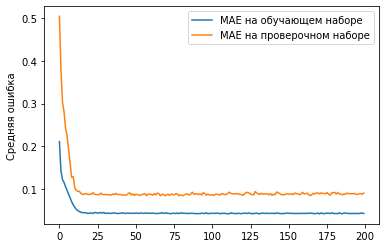

In [14]:
plt.plot(history.history['mae'], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [15]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])

trainScore = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 21ms/step
Train Score: 27.91 RMSE
Test Score: 55.43 RMSE


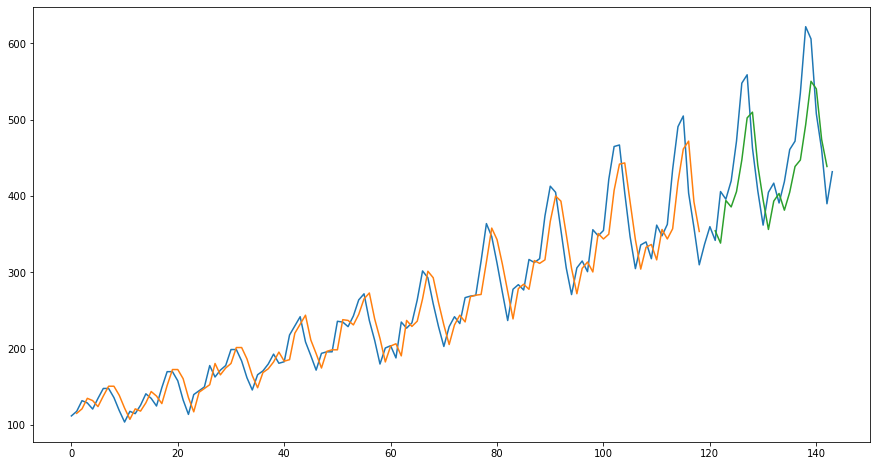

In [16]:
trainPredictPlot = np.empty_like(df_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(df_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_norm)-1, :] = testPredict

plt.figure(figsize=(15, 8))
plt.plot(scaler.inverse_transform(df_norm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<font size = 3><div style="text-align: justify">**Вариант 2:**</div></font>

In [50]:
df = pd.read_csv('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки/airline-passengers.csv')
df = df['Passengers'].values.astype(float)
df

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [51]:
scaler = MinMaxScaler(feature_range=(0, 1)) #feature_range=(-1, 1)
df_norm = scaler.fit_transform(df.reshape(-1, 1))
df_norm

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [53]:
df_train = df_norm[:-24]
df_test = df_norm[-24:]

In [37]:
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(trainset)

In [57]:
window = 4

x_train = []
y_train = []

for i in range(window, len(df_train)):
    x_train.append(df_train[i-window:i, 0])
    y_train.append(df_train[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [58]:
window = 4

x_test = []
y_test = []

for i in range(window, len(df_test)):
    x_test.append(df_test[i-window:i, 0])
    y_test.append(df_test[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [59]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [60]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
##regressor.add(LSTM(units = 50,return_sequences = True)) # Activate it to see effect
##regressor.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 4, 50)             10400     
                                                                 
 dropout_6 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 4, 50)             20200     
                                                                 
 dropout_7 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [61]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

In [62]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)

In [28]:
#opt = keras.optimizers.Adam(lr = 0.5e-2)

C:\Users\skapr\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [63]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

history = model.fit(x_train, y_train, 
                    epochs = 150, 
                    batch_size = 1, 
                    verbose = 1,
                    callbacks=[mc, lr_schedule, early_stopping])

Epoch 1/150
116/116 [==============================] - 6s 5ms/step - loss: 0.1128 - mae: 0.2832 - lr: 1.0000e-07
Epoch 2/150
116/116 [==============================] - 0s 4ms/step - loss: 0.1129 - mae: 0.2831 - lr: 1.1220e-07
Epoch 3/150
116/116 [==============================] - 0s 4ms/step - loss: 0.1126 - mae: 0.2828 - lr: 1.2589e-07
Epoch 4/150
116/116 [==============================] - 1s 4ms/step - loss: 0.1126 - mae: 0.2827 - lr: 1.4125e-07
Epoch 5/150
116/116 [==============================] - 0s 4ms/step - loss: 0.1125 - mae: 0.2826 - lr: 1.5849e-07
Epoch 6/150
116/116 [==============================] - 0s 4ms/step - loss: 0.1122 - mae: 0.2823 - lr: 1.7783e-07
Epoch 7/150
116/116 [==============================] - 0s 4ms/step - loss: 0.1121 - mae: 0.2822 - lr: 1.9953e-07
Epoch 8/150
116/116 [==============================] - 0s 4ms/step - loss: 0.1124 - mae: 0.2822 - lr: 2.2387e-07
Epoch 9/150
116/116 [==============================] - 0s 4ms/step - loss: 0.1118 - mae: 0.2816 

Epoch 73/150
116/116 [==============================] - 0s 4ms/step - loss: 0.0118 - mae: 0.0800 - lr: 3.9811e-04
Epoch 74/150
116/116 [==============================] - 0s 4ms/step - loss: 0.0139 - mae: 0.0876 - lr: 4.4668e-04
Epoch 75/150
116/116 [==============================] - 0s 4ms/step - loss: 0.0128 - mae: 0.0853 - lr: 5.0119e-04
Epoch 76/150
116/116 [==============================] - 0s 4ms/step - loss: 0.0115 - mae: 0.0806 - lr: 5.6234e-04
Epoch 77/150
116/116 [==============================] - 0s 4ms/step - loss: 0.0126 - mae: 0.0852 - lr: 6.3096e-04
Epoch 78/150
116/116 [==============================] - 0s 4ms/step - loss: 0.0139 - mae: 0.0856 - lr: 7.0795e-04
Epoch 79/150
116/116 [==============================] - 0s 4ms/step - loss: 0.0150 - mae: 0.0952 - lr: 7.9433e-04


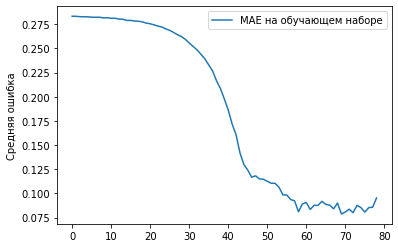

In [64]:
plt.plot(history.history['mae'], 
         label='MAE на обучающем наборе')
#plt.plot(history.history['val_mae'], 
#         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [68]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [69]:
from keras.models import load_model

model = load_model('best_model.h5')

trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 20ms/step
Train Score: 57.96 RMSE
Test Score: 107.76 RMSE


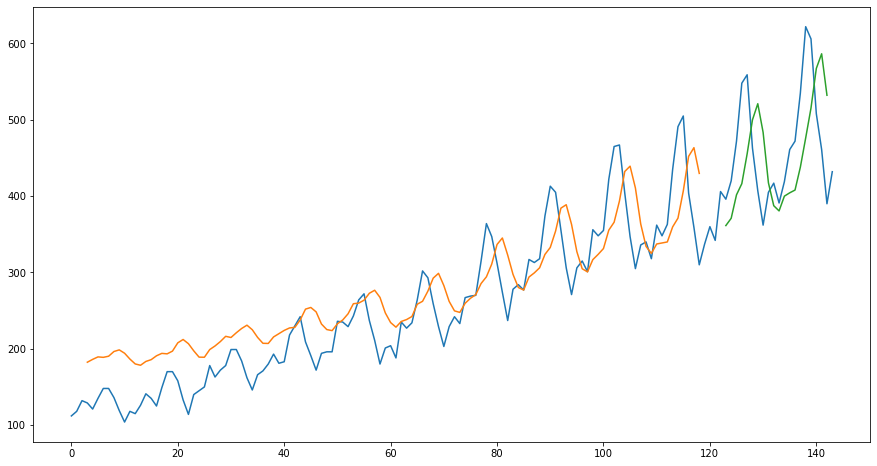

In [71]:
trainPredictPlot = np.empty_like(df_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[3:len(trainPredict)+3, :] = trainPredict

testPredictPlot = np.empty_like(df_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(3*2)+1:len(df_norm)-1, :] = testPredict

plt.figure(figsize=(15, 8))
plt.plot(scaler.inverse_transform(df_norm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<font size = 3><div style="text-align: justify">**Вывод:**</div></font>

Наилучшим вариантом является Вариант 1.